Intercept: 12.21
Coefficients: Max Temp: 0.45, Rainfall: -0.06, Public Holiday: 8.86
Simulated Revenue per Person with Base Price: $62.00
Simulated Revenue per Person with Dynamic Pricing: $61.91
Simulated Revenue Increase with Dynamic Pricing: -0.15%


/var/folders/y7/rwvr_w4d365bdb115zclvwpc0000gn/T/ipykernel_47328/3875414039.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df['Maximum Temperature (°C)'].fillna(weather_df['Maximum Temperature (°C)'].median(), inplace=True)
/var/folders/y7/rwvr_w4d365bdb115zclvwpc0000gn/T/ipykernel_47328/3875414039.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becau

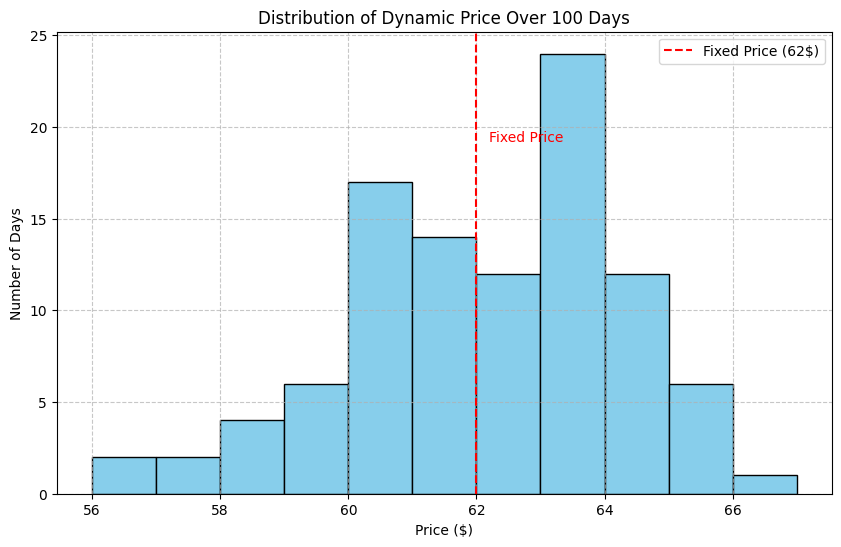

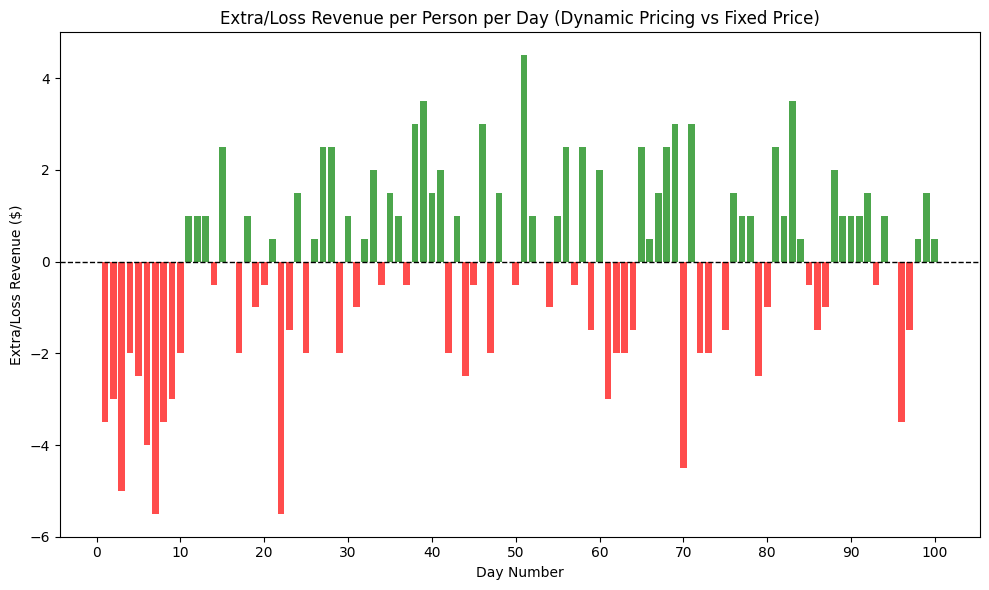

In [3]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

random.seed(3101)
np.random.seed(3101)

weather_df = pd.read_csv('../data/2023_daily_weather_with_wait_times_and_conditions.csv')

weather_df['Maximum Temperature (°C)'].fillna(weather_df['Maximum Temperature (°C)'].median(), inplace=True)
weather_df['Daily Rainfall Total (mm)'].fillna(weather_df['Daily Rainfall Total (mm)'].median(), inplace=True)
weather_df['Public Holiday'].fillna(0, inplace=True)

base_price = 62

avg_wait_time = weather_df['Wait Time'].mean()
avg_max_temp = weather_df['Maximum Temperature (°C)'].mean()
avg_rainfall = weather_df['Daily Rainfall Total (mm)'].mean()

heavy_rain_threshold = 35
high_temp_threshold = avg_max_temp

def scale_column(df, col_name):
    median = df[col_name].median()
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    shifted_values = df[col_name] - median
    scale_factor = 20 / (max_val - min_val)
    scaled_values = shifted_values * scale_factor
    return scaled_values

weather_df['Scaled Maximum Temperature'] = scale_column(weather_df, 'Maximum Temperature (°C)')

X = weather_df[['Maximum Temperature (°C)', 'Daily Rainfall Total (mm)', 'Public Holiday']]
y = weather_df['Wait Time']

model = LinearRegression()
model.fit(X, y)

coefficients = model.coef_
intercept = model.intercept_

print(f"Intercept: {intercept:.2f}")
print(f"Coefficients: Max Temp: {coefficients[0]:.2f}, Rainfall: {coefficients[1]:.2f}, Public Holiday: {coefficients[2]:.2f}")

num_days = 100
num_public_holidays = 10

random_max_temps = np.random.normal(loc=avg_max_temp, scale=5, size=num_days)
random_rainfall = np.random.normal(loc=avg_rainfall, scale=5, size=num_days)
public_holiday_flags = np.array([1]*num_public_holidays + [0]*(num_days - num_public_holidays))

simulated_data = pd.DataFrame({
    'Date': pd.date_range(start="2023-11-01", periods=num_days, freq='D'),
    'Maximum Temperature (°C)': random_max_temps,
    'Daily Rainfall Total (mm)': random_rainfall,
    'Public Holiday': public_holiday_flags
})

simulated_data['Predicted Wait Time'] = model.predict(simulated_data[['Maximum Temperature (°C)', 'Daily Rainfall Total (mm)', 'Public Holiday']])

simulated_data['Scaled Maximum Temperature'] = scale_column(simulated_data, 'Maximum Temperature (°C)')

def scale_predicted_wait_time(df, col_name, median_wait_time):
    median_val = df[col_name].median()
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    
    shifted_values = df[col_name] - median_wait_time
    scale_factor = 20 / (max_val - min_val)
    scaled_values = shifted_values * scale_factor
    
    return scaled_values

simulated_data['Scaled Predicted Wait Time'] = scale_predicted_wait_time(simulated_data, 'Predicted Wait Time', median_wait_time=avg_wait_time)

def scale_satisfaction_score(df, col_name):
    median_val = df[col_name].median()
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    
    shifted_values = df[col_name] - median_val

    scale_factor = 10 / (max_val - min_val)  
    scaled_values = shifted_values * scale_factor
    
    return scaled_values

def calculate_satisfaction(row):
    satisfaction_score = 5
    satisfaction_score -= row['Scaled Predicted Wait Time']
    satisfaction_score -= row['Scaled Maximum Temperature']
    
    if row['Daily Rainfall Total (mm)'] > heavy_rain_threshold:
        satisfaction_score -= 2.5
    
    return satisfaction_score

def calculate_dynamic_price(satisfaction_score):
    price = 62 + satisfaction_score
    rounded_price = np.ceil(price * 2) / 2
    return rounded_price

simulated_data['Satisfaction Score'] = simulated_data.apply(calculate_satisfaction, axis=1)
simulated_data['Scaled Satisfaction Score'] = scale_satisfaction_score(simulated_data, 'Satisfaction Score')
simulated_data['Dynamic Price'] = simulated_data['Scaled Satisfaction Score'].apply(calculate_dynamic_price)

simulated_revenue_base = simulated_data.shape[0] * base_price /100
simulated_revenue_dynamic = simulated_data['Dynamic Price'].sum() /100

print(f"Simulated Revenue per Person with Base Price: ${simulated_revenue_base:.2f}")
print(f"Simulated Revenue per Person with Dynamic Pricing: ${simulated_revenue_dynamic:.2f}")

simulated_revenue_increase = (simulated_revenue_dynamic - simulated_revenue_base) / simulated_revenue_base * 100
print(f"Simulated Revenue Increase with Dynamic Pricing: {simulated_revenue_increase:.2f}%")

min_price = int(simulated_data['Dynamic Price'].min())
max_price = int(simulated_data['Dynamic Price'].max())

price_bins = np.arange(min_price, max_price + 2, 1)

price_hist, bin_edges = np.histogram(simulated_data['Dynamic Price'], bins=price_bins)

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], price_hist, width=1, edgecolor='black', align='edge', color='skyblue')
plt.axvline(x=62, color='red', linestyle='--', label='Fixed Price (62$)')
plt.text(62 + 0.2, max(price_hist) * 0.8, 'Fixed Price', color='red')
plt.xlabel('Price ($)')
plt.ylabel('Number of Days')
plt.title('Distribution of Dynamic Price Over 100 Days')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

simulated_data['Extra Revenue'] = simulated_data['Dynamic Price'] - 62

bar_colors = ['green' if x > 0 else 'red' for x in simulated_data['Extra Revenue']]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, num_days+1), simulated_data['Extra Revenue'], color=bar_colors, alpha=0.7)
plt.title('Extra/Loss Revenue per Person per Day (Dynamic Pricing vs Fixed Price)')
plt.xlabel('Day Number')
plt.ylabel('Extra/Loss Revenue ($)')
plt.xticks(range(0, num_days+1, 10))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


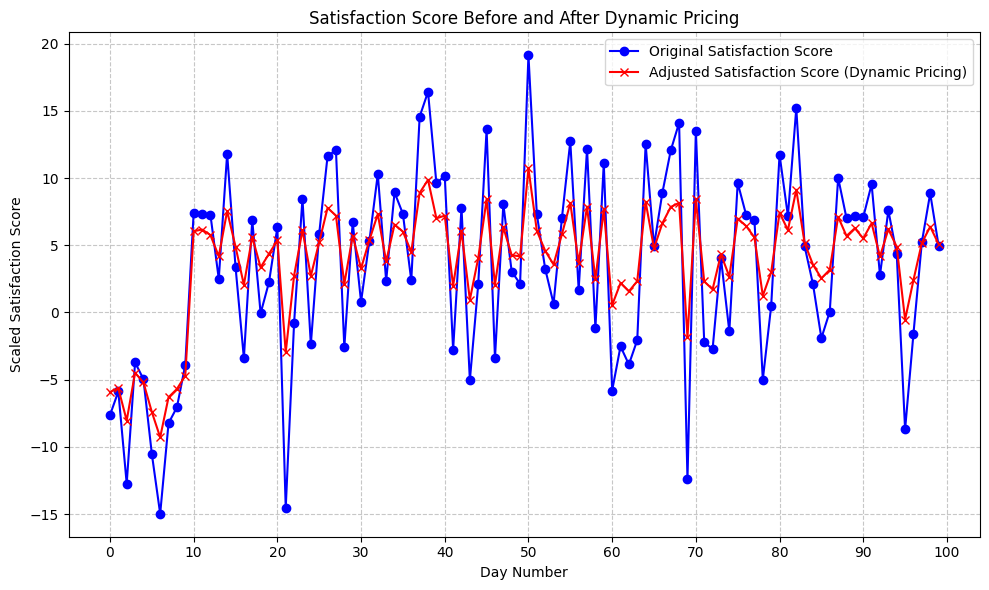

Simulated Satisfaction Increase with Dynamic Pricing: 11.37%


In [4]:
def calculate_satisfaction_new(row):
    satisfaction_score = 5
    satisfaction_score -= row['Scaled Predicted Wait Time'] 
    
    return satisfaction_score

simulated_data['New Satisfaction Score'] = simulated_data.apply(calculate_satisfaction_new, axis=1)

plt.figure(figsize=(10, 6))

plt.plot(range(num_days), simulated_data['Satisfaction Score'], label='Original Satisfaction Score', color='blue', linestyle='-', marker='o')

plt.plot(range(num_days), simulated_data['New Satisfaction Score'], label='Adjusted Satisfaction Score (Dynamic Pricing)', color='red', linestyle='-', marker='x')

plt.xlabel('Day Number')
plt.ylabel('Scaled Satisfaction Score')
plt.title('Satisfaction Score Before and After Dynamic Pricing')
plt.legend()

plt.xticks(np.arange(0, num_days+1, 10))

plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

simulated_satisfactoin_dynamic = simulated_data['New Satisfaction Score'].mean()
simulated_satisfactoin_base = simulated_data['Satisfaction Score'].mean()

simulated_satisfactoin_increase = (simulated_satisfactoin_dynamic -
                                   simulated_satisfactoin_base) / simulated_satisfactoin_base * 100
print(f"Simulated Satisfaction Increase with Dynamic Pricing: {simulated_satisfactoin_increase:.2f}%")

